In [1]:
import os
from matplotlib import test
import tensorflow as tf
# import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras import datasets, layers, models

In [159]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Establish YOLOv1 Output
S = 7
B = 1   # Single Box
C = 1   # Melanoma or Benign

In [3]:
data_path = "../../../ISIC_Data/ISIC-2017_Training_Data/*.jpg"
mask_path = "../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/*.png"

In [4]:
# Process ground truth csv
import csv
import pathlib
filename = "ISIC_0000000"
img_path = "../../../ISIC_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg"

with open("../../../ISIC_Data/ISIC-2017_Training_Part3_GroundTruth.csv", "r") as infile:
    data_groundtruth_dict = list(csv.DictReader(infile))

In [5]:
def prepareData(filenames):
    # Lookup image in ground truth csv to determine if malignant or benign
    # image_id = tf.strings.split(filenames, "/")[-1]  # Get filename
    # image_id = tf.strings.split(image_id, ".")[0]      # Remove file extension

    # # Look up image in csv to determine label
    # for row in data_groundtruth_dict:
    #     if row['image_id'] == image_id:
    #         label = tf.strings.to_number(row['melanoma'])
    #     else:
    #         label = tf.strings.to_number('0.0')

    raw_image = tf.io.read_file(filenames)
    raw_image = tf.io.decode_jpeg(raw_image, channels=3)

    # Resize
    raw_image = tf.image.resize_with_pad(raw_image, IMAGE_HEIGHT, IMAGE_WIDTH)

    # Normalise
    raw_image = raw_image / 255.0

    return raw_image #, label


def prepareMasks(filenames):
    new_img = tf.io.read_file(filenames)
    raw_image = tf.io.decode_png(new_img, channels=1)

    # Resize
    raw_image = tf.image.resize_with_pad(raw_image, IMAGE_HEIGHT, IMAGE_WIDTH)

    # Normalise
    raw_image = raw_image / 255.0

    # Set image thresholds
    raw_image = tf.math.round(raw_image)

    return raw_image

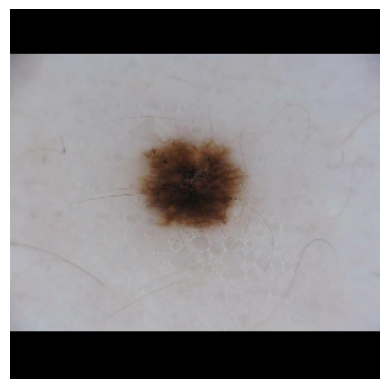

In [6]:
image = prepareData("../../../ISIC_Data/ISIC-2017_Training_Data/ISIC_0000001.jpg")

# def show(image, label):
#     plt.figure()
#     plt.imshow(image)
#     plt.title("melanoma" if label.numpy() == 1.0 else "benign")
#     plt.axis('off')

def show(image):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

show(image)

def process_raw(data_path, mask_path):
    data = prepareData(data_path)

    mask = prepareMasks(mask_path)

    return data, mask

In [9]:
import glob

g_data = sorted(glob.glob(data_path))

In [187]:
def indicies_by_value(value):
    return tf.where(tf.equal(value, True))[:, -1]

def mask_to_bounding_box(mask_image):
    # Takes mask as input and outputs bounding box Tensor
    rows = tf.math.count_nonzero(mask_image, axis=0, keepdims=None, dtype=tf.bool)
    rows = tf.squeeze(rows, axis=1)
    row_index = indicies_by_value(rows)

    columns = tf.math.count_nonzero(mask_image, axis=1, keepdims=None, dtype=tf.bool)
    columns = tf.squeeze(columns, axis=1)
    # Convert to indicies
    col_index = indicies_by_value(columns)

    y_min = col_index[0]    # First mask pixel
    y_max = col_index[-1]   # Last mask pixel
    x_min = row_index[0]    
    x_max = row_index[-1]

    image = tf.image.convert_image_dtype(mask_image, dtype=tf.float32)
    img = tf.expand_dims(image, axis=0)
    img = tf.reshape(img, shape=[1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

    box = tf.stack([y_min, x_min, y_max, x_max], axis=0)
    box = tf.math.divide(box, IMAGE_HEIGHT)
    box = box.numpy()
    box = box.reshape([1,1,4])

    return box
    # box = np.array([0.1, 0.2, 0.5, 0.9])
    # box = tf.convert_to_tensor(box, dtype="float32")
    # box = tf.reshape(box, [1, 1, 4])

image = prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000000_segmentation.png')

print(image.shape)
box = mask_to_bounding_box(image)
box = tf.squeeze(box)

print(box)


(256, 256, 1)
tf.Tensor([0.16796875 0.05078125 0.73828125 0.875     ], shape=(4,), dtype=float64)


In [186]:
def box_details_extraction(box):
    # Box format -> y_min, x_min, y_max, x_max
    # Determine center coordinates
    y_min = box[0][0][0]
    x_min = box[0][0][1]
    y_max = box[0][0][2]
    x_max = box[0][0][3]

    width = tf.math.subtract(x_max, x_min)
    height = tf.math.subtract(y_max, y_min)

    center_x = x_min + tf.math.divide(width, 2.0)
    center_y = y_min + tf.math.divide(height, 2.0)

    return np.array([center_x, center_y, width, height])

image = prepareMasks('../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/ISIC_0000154_segmentation.png')
box = mask_to_bounding_box(image)

print(box_details_extraction(box))

[0.55078125 0.46875    0.3671875  0.328125  ]


In [195]:
# Generate .txt files for each mask
# In YOLO form -> Prob, b_center_x, b_center_y, b_width, b_height, class
# Where 0 is benign and 1 is melenoma

def get_mask_id(mask_path):
    mask_id = mask_path.split("\\")[-1]  # Get filename
    mask_id = mask_id.split("_segmentation")[0]  # Remove file extension

    return mask_id

def yolo_mask_encode(mask_path, mask_id):
    # Look up image in csv to determine label
    label = 0   # Benign
    for row in data_groundtruth_dict:
        if row['image_id'] == mask_id:
            label = tf.strings.to_number(row['melanoma'])
            break

    label = tf.cast(label, dtype=tf.int32)

    mask_image = prepareMasks(mask_path)

    bounding_box = mask_to_bounding_box(mask_image)

    box_details = box_details_extraction(bounding_box)
    
    yolo_format = tf.convert_to_tensor([1, box_details[0], box_details[1], box_details[2], box_details[3], label], dtype=tf.float32)
    # yolo_format = tf.strings.join([1, box_details[0], box_details[1], box_details[2], box_details[3], label])
    
    return yolo_format



    


In [196]:
# Export masks to txt files in Data local folder
mask_image_folder_path = "../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth/*.png"
mask_image_paths = sorted(glob.glob(mask_image_folder_path))
save_folder = "../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth_YOLO/"
for mask_path in mask_image_paths:
    mask_id = get_mask_id(mask_path)
    yolo_data = yolo_mask_encode(mask_path, mask_id)
    yolo_data_str = str(tf.get_static_value(yolo_data))
    
    tf.io.write_file(f"{save_folder}{mask_id}.txt", yolo_data_str[1:-1])

In [211]:
# Function to convert text file yolo data to tensor
def prepareYoloFromTxt(filepath):
    text_file = open(filepath, "r")
    words = text_file.readline().split()
    words = tf.strings.to_number(words)
    n = np.array(words)
    text_file.close()

    return words

yolo_masks = sorted(glob.glob("../../../ISIC_Data/ISIC-2017_Training_Part1_GroundTruth_YOLO/*.txt"))

In [222]:
import math

def outputFromYolo(yolo_box):
    # YOLO form -> Prob, b_center_x, b_center_y, b_width, b_height, class
    output = tf.zeros([S, S, B*5+1])

    prob = yolo_box.numpy()[0]
    b_center_x = yolo_box.numpy()[1]
    b_center_y = yolo_box.numpy()[2]
    b_width = yolo_box.numpy()[3]
    b_height = yolo_box.numpy()[4]
    label = yolo_box.numpy()[5]

    box_col = math.floor(b_center_x * S)
    box_row = math.floor(b_center_y * S)

    indices = [[box_row, box_col, 0], 
               [box_row, box_col, 1],
               [box_row, box_col, 2],
               [box_row, box_col, 3],
               [box_row, box_col, 4],
               [box_row, box_col, 5]]

    updates = yolo_box

    output = tf.tensor_scatter_nd_add(output, indices, updates)

    return output

In [225]:
def process_data(data_path, boxes):
    data = prepareData(data_path)
    # boxes = outputFromYolo(boxes)
    
    return data, boxes

In [228]:
# Generate

# List of boxes for each image
boxes = [outputFromYolo(prepareYoloFromTxt(path)) for path in yolo_masks]
full_ds = tf.data.Dataset.from_tensor_slices((g_data, boxes))
full_ds = full_ds.map(process_data)

print(full_ds)

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(7, 7, 6), dtype=tf.float32, name=None))>


In [157]:
BATCH_SIZE = 6
batch_ds = train_ds.batch(BATCH_SIZE)

# for image in batch_ds.take(4):
i = 0
it = iter(batch_ds)

while i < BATCH_SIZE:
    image, mask = next(it)

    print(image.shape, mask.shape)
    # show(image.numpy()[0])
    # show(mask.numpy()[0])

    box = mask_to_bounding_box(mask.numpy()[0])
    colour = [[1.0, 0.0, 0.0]]
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image[0], [1, 256, 256, 3])

    print('pre show dims')
    print(image[0].shape, box)
    bbox = tf.image.draw_bounding_boxes(image, box, colour)

    show(bbox.numpy()[0])
    i += 1

(6, 256, 256, 3) (6, 6)


InvalidArgumentError: Tried to squeeze dim index 1 for tensor with 0 dimensions. [Op:Squeeze]

In [244]:
# Divide data into subsets
training_subset = round(0.8 * 2000)
validation_subset = round(0.1 * 2000)
test_subset = round(0.1 * 2000)

train_ds = full_ds.take(training_subset)
middle_ds = full_ds.skip(training_subset)
val_ds = middle_ds.skip(validation_subset)
test_ds = middle_ds.take(test_subset)

In [246]:
# Establish Batches
train_batches = train_ds.batch(BATCH_SIZE)
test_batches = test_ds.batch(BATCH_SIZE)
val_batches = val_ds.batch(BATCH_SIZE)